## GiGL Pipeline Visualization
This notebook shows the process of a simple, human-digestable graph being passed through all the pipeline components in GiGL in preperation for training to help understand how each of the components work.

The pipeline consists of the following components:

- **Config Populator**: Takes a template config and creates a frozen workflow config that dictates all inputs/outputs and business parameters that is read and used by each subsequent component.
    - input: template_config.yaml
    - output: frozen_gbml_config.yaml
&nbsp;

&nbsp;


- **Data Preprocesser**: Transforms necessary node and edge feature assets as needed as a precursor step in most ML tasks according to user provided data preprocessor config class
    - input: frozen_gbml_config.yaml which includes user-defined preprocessor class for custom logic and custom arguments can be passed under dataPreprocessorArgs
    - output: PreprocessedMetadata Proto which includes inferred GraphMetadata and preproccessed graph data Tfrecords after applying user defined preprocessing function
&nbsp;

&nbsp;


- **Subgraph Sampler**: Samples k-hop subgraphs for each node according to user provided arguments
    - input: frozen_gbml_config.yaml, resource_config.yaml
    - output: Subgraph Samples (tfrecord format based on predefined schema in protos) are stored in the uri defined in flattenedGraphMetadata field. 
&nbsp;

&nbsp;


- **Split Generator**: Splits subgraph sampler outputs into train/test/val sets according to user provided split strategy class.
    - input: frozen_gbml_config.yaml which includes instance of SplitStrategy and an instance of Assigner
    - output: TFRecord samples
&nbsp;

&nbsp;


- **Trainer**: The trainer component reads the output of split generator and trains a model on the training set, stops based on validation set, and evaluates on the test set
    - input: frozen_gbml_config.yaml
    - output: state_dict stored in trainedModelUri
&nbsp;

&nbsp;


- **Inferencer**: Runs inference of a trained model on samples generated by Subgraph Sampler. 
    - input: frozen_gbml_config.yaml
    - output: Embeddings and/or prediction assets
&nbsp;

&nbsp;


Note: You can run this visualization with your own custom graph by modifying [this config](./graph_config.yaml). The example graph configuration is outputted below.

In [5]:
import yaml

yaml_file = "./graph_config.yaml"

def visualize_yaml(file_path):
    with open(file_path, 'r') as yaml_file:
        yaml_data = yaml.safe_load(yaml_file)

    print(yaml.dump(yaml_data))

print("Graph Configuration Yaml:")
visualize_yaml(yaml_file)

Graph Configuration Yaml:
adj_list:
- dst:
  - 1
  - 3
  src: 0
- dst:
  - 0
  - 5
  src: 1
- dst:
  - 1
  src: 2
- dst:
  - 0
  - 5
  - 6
  - 7
  src: 3
- dst:
  - 3
  src: 4
- dst:
  - 1
  - 3
  - 6
  src: 5
- dst:
  - 2
  - 3
  - 7
  src: 6
- dst:
  - 3
  - 6
  - 8
  - 9
  src: 7
- dst:
  - 7
  - 9
  - 10
  src: 8
- dst:
  - 7
  - 8
  - 10
  src: 9
- dst:
  - 11
  - 9
  - 8
  src: 10
- dst:
  - 12
  src: 11
- dst:
  - 13
  src: 12
- dst: []
  src: 13
graph:
  edge_type:
    dst_node_type: user
    relation_type: friend
    src_node_type: user
  node_type: user
nodes:
- features:
  - 0.0
  - 0
  src: 0
- features:
  - 0.1
  - 1
  src: 1
- features:
  - 0.2
  - 2
  src: 2
- features:
  - 0.3
  - 3
  src: 3
- features:
  - 0.4
  - 4
  src: 4
- features:
  - 0.5
  - 5
  src: 5
- features:
  - 0.6
  - 6
  src: 6
- features:
  - 0.7
  - 7
  src: 7
- features:
  - 0.8
  - 8
  src: 8
- features:
  - 0.9
  - 9
  src: 9
- features:
  - 0.01
  - 10
  src: 10
- features:
  - 0.11
  - 11
  src: 

### Getting Started

The first thing you will need to do is create a template config for this job. This config file contains various information that will be referenced throughout the pipeline to pass certain parameters to each component.
The one that will be used in this notebook can be found [Here](../../../../../internal/applied_tasks/mocking/toy_graph/configs/gbml_toy_config.yaml). The contents of this file are visualized below.

In [19]:
import yaml

yaml_file = "../../../../../internal/applied_tasks/mocking/toy_graph/configs/gbml_toy_config.yaml"

def visualize_yaml(file_path):
    with open(file_path, 'r') as yaml_file:
        yaml_data = yaml.safe_load(yaml_file)

    print(yaml.dump(yaml_data))

print("GBML Config for Toy Graph:")
visualize_yaml(yaml_file)

GBML Config for Toy Graph:
datasetConfig:
  dataPreprocessorConfig:
    dataPreprocessorArgs:
      bq_edges_table_name: external-snap-ci-github-gigl.gbml_mocked_assets.toy_graph_user_friend_user_edges
      bq_nodes_table_name: external-snap-ci-github-gigl.gbml_mocked_assets.toy_graph_user_nodes
    dataPreprocessorConfigClsPath: applied_tasks.mocking.toy_graph.toy_data_preprocessor_config.ToyDataPreprocessorConfig
  splitGeneratorConfig:
    assignerArgs:
      seed: '42'
      test_split: '0.2'
      train_split: '0.7'
      val_split: '0.1'
    assignerClsPath: gigl.src.split_generator.lib.unsupervised_node_anchor_based_link_prediction.transductive.TransductiveEdgeToLinkSplitHashingAssigner
    splitStrategyClsPath: gigl.src.split_generator.lib.unsupervised_node_anchor_based_link_prediction.transductive.TransductiveUnsupervisedNodeAnchorBasedLinkPredictionSplitStrategy
  subgraphSamplerConfig:
    numHops: 1
    numNeighborsToSample: 2
    numPositiveSamples: 1
inferencerConfig:
  



The graph/data type you are using must have an instance of the `DataPreprocessorConfig` class (see `dataPreprocessorConfigClsPath` field of `datasetConfig.dataPreprocessorConfig`). For more information on this class, see the DataPreprocessor Section

A toy graph preprocessor class can be found [Here](../../../../../internal/applied_tasks/mocking/toy_graph/toy_data_preprocessor_config.py) which will be used in the config for this notebook's demonstration

Alternatively, you can pass in  `bq_edges_table_name` and `bq_nodes_table_name` in the config file as runtime arguments under dataPreprocessorArgs. These two indicate where the graphs can be found in BigQuery and additional prepare_for_pipeline logic is not needed for pulling data since it is already implemented in the [ToyDataPreprocessorConfig Class](https://github.sc-corp.net/Snapchat/GiGL/blob/622d5b5c5f5dcb07a07b52e7e85848bc318537e8/internal/applied_tasks/mocking/toy_graph/toy_data_preprocessor_config.py#L38). You can use the [Mocking Suite](../dataset_asset_mocking_suite.py) to populate BigQuery with the custom graph that was configured in the [graph_config.yaml](./graph_config.yaml). There is a method in the mocking suite called `_create_custom_toy_graph` which will be used in the `mock_toy_graph_homogeneous_unsupervised_node_anchor_based_link_prediction_dataset` function to populate the custom graph in BigQuery. The steps to do this are the following:

1. Locate the `mock_toy_graph_homogeneous_unsupervised_node_anchor_based_link_prediction_dataset` in the mocking suite. 
2. Set toy_graph = self._create_custom_toy_graph("PATH/TO/GRAPH_CONFIG.yaml")
3. Change the name parameter (Note: this is the prefix of the name that will appear in BigQuery)
4. Run the command seen below:



In [ ]:
%%bash

cd ~/GiGL

cd python && python -m tests.test_assets.dataset_mocking.dataset_asset_mocking_suite  --select mock_toy_graph_homogeneous_unsupervised_node_anchor_based_link_prediction_dataset  --env test

### Config Populator

Now that the graph data has been populated and reflected in the config, we can proceed to the first step of the pipeline. The Config Populator takes a "template" config and generates a "frozen" config to be used by all subsequent components. The frozen config contains some information that is not in the original config but is needed for other parts of the pipeline. To run config poplulator we can just do the following:

In [ ]:
%%bash
PYTHONPATH="/home/$(whoami)/GiGL/TODO/:$PYTHONPATH" python -m \
    gigl.src.config_populator.config_populator \
    --job_name toy_graph \
    --template_uri /home/$(whoami)/GiGL/TODO/applied_tasks/mocking/toy_graph/configs/gbml_toy_config.yaml \
    --output_file_path_frozen_gbml_config_uri /home/$(whoami)/GiGL/TODO/applied_tasks/mocking/toy_graph/configs/toy_graph-frozen-config_path.yaml

So, now we have:

In [12]:
from gigl.common.utils.proto_utils import ProtoUtils
from gigl.common import UriFactory
from snapchat.research.gbml import gbml_config_pb2

frozen_config_uri = "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml"

# Frozen config proto
proto_utils = ProtoUtils()
frozen_config = proto_utils.read_proto_from_yaml(
        uri=UriFactory.create_uri(
            uri=frozen_config_uri
        ),
        proto_cls=gbml_config_pb2.GbmlConfig,
    )

2023-06-16 18:54:19,045[INFO]gigl.common.utils.gcs-140646927939392@__download_blob_from_gcs : Downloading gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml to /var/tmp/tmpz6y_y6yf


In [4]:
# Copy frozen config to local
!gsutil cp gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml .

import yaml

yaml_file = "./frozen_gbml_config.yaml"

def visualize_yaml(file_path):
    with open(file_path, 'r') as yaml_file:
        yaml_data = yaml.safe_load(yaml_file)

    print(yaml.dump(yaml_data))

print("Frozen GBML Config Yaml:")
visualize_yaml(yaml_file)

Copying gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml...
/ [1 files][  3.7 KiB/  3.7 KiB]                                                
Operation completed over 1 objects/3.7 KiB.                                      
Frozen GBML Config Yaml:
datasetConfig:
  dataPreprocessorConfig:
    dataPreprocessorArgs:
      bq_edges_table_name: external-snap-ci-github-gigl.gbml_mocked_assets.toy_graph_user_friend_user_edges
      bq_nodes_table_name: external-snap-ci-github-gigl.gbml_mocked_assets.toy_graph_user_nodes
    dataPreprocessorConfigClsPath: applied_tasks.mocking.toy_graph.toy_data_preprocessor_config.ToyDataPreprocessorConfig
  splitGeneratorConfig:
    assignerArgs:
      seed: '42'
      test_split: '0.2'
      train_split: '0.7'
      val_split: '0.1'
    assignerClsPath: gigl.src.split_generator.lib.unsupervised_node_anchor_based_link_prediction.transductive.TransductiveEdgeToLinkSplitHashingAssigner
    splitStrategyClsPath: gigl.src.split_g

Below is a code snippet to output the difference between the original config file and the frozen config to illustrate what ConfigPopulator adds

In [11]:
import yaml

def compare_yaml(file_path1, file_path2):
    with open(file_path1, 'r') as yaml_file1:
        yaml_data1 = yaml.safe_load(yaml_file1)

    with open(file_path2, 'r') as yaml_file2:
        yaml_data2 = yaml.safe_load(yaml_file2)

    diff = compare_dicts(yaml_data1, yaml_data2)
    print(yaml.dump(diff, default_flow_style=False))

def compare_dicts(dict1, dict2):
    diff = {}
    for key in set(dict2.keys()):
        if key not in dict1:
            diff[key] = dict2[key]
    return diff

gbml_config = "../../../../../internal/applied_tasks/mocking/toy_graph/configs/gbml_toy_config.yaml"
frozen_config_local = "./frozen_gbml_config.yaml"
compare_yaml(gbml_config, frozen_config_local)

sharedConfig:
  datasetMetadata:
    unsupervisedNodeAnchorBasedLinkPredictionDataset:
      testMainDataUri: gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/test/main_samples/samples/
      testRandomNegativeDataUri: gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/test/random_negatives/neighborhoods-
      trainMainDataUri: gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/train/main_samples/samples/
      trainRandomNegativeDataUri: gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/train/random_negatives/neighborhoods-
      valMainDataUri: gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/val/main_samples/samples/
      valRandomNegativeDataUri: gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/val/random_negatives/neighborhoods-
  flattenedGraphMetadata:
    unsupervisedNodeAnchorBasedLinkPredictionOutput:
      randomNegativeTfrecordUriPrefix: gs://TEMP DEV GBML PLACEHOLDER/toy_graph/subgraph_sampler/unsupervised_node_anchor_based_link

### Visualizing Input Graph

We have now configured everything required to run the subsequent steps. Before proceeding we can visualize what the input graph looks like to get a better understanding of what happens in each of the steps.

{'src': 0, 'dst': [1, 3]}
{'src': 1, 'dst': [0, 5]}
{'src': 2, 'dst': [1]}
{'src': 3, 'dst': [0, 5, 6, 7]}
{'src': 4, 'dst': [3]}
{'src': 5, 'dst': [1, 3, 6]}
{'src': 6, 'dst': [2, 3, 7]}
{'src': 7, 'dst': [3, 6, 8, 9]}
{'src': 8, 'dst': [7, 9, 10]}
{'src': 9, 'dst': [7, 8, 10]}
{'src': 10, 'dst': [11, 9, 8]}
{'src': 11, 'dst': [12]}
{'src': 12, 'dst': [13]}
{'src': 13, 'dst': []}


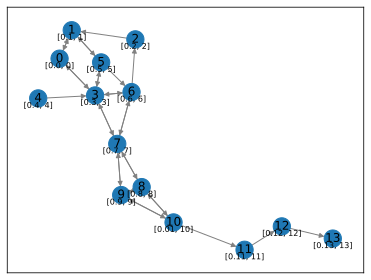

In [12]:
from visualize import GraphVisualizer

%config InlineBackend.figure_format = 'svg'

graph_visualizer = GraphVisualizer("./graph_config.yaml")
graph_visualizer.visualize_graph()

### Data Preprocessor

The Data Preprocessor uses Tensorflow Transform to achieve data transformation in a distributed fashion. Any custom preprocessing is to be defined in the preprocessor class that is inherited from the DataPreprocessorConfig class.

Overall, this class houses all logic for

- Preparing datasets for ingestion and transformation (see [`prepare_for_pipeline`](https://github.sc-corp.net/Snapchat/GiGL/blob/10f1a35196f3946ae14c3e8e57d1cb685f01ffb5/python/gigl/src/data_preprocessor/lib/data_preprocessor_config.py#L40) function) So this is where you would house logic to pull data from a custom data source or perform any specific transformations.
- Defining transformation imperatives for different node types (see [`get_nodes_preprocessing_spec`](https://github.sc-corp.net/Snapchat/GiGL/blob/10f1a35196f3946ae14c3e8e57d1cb685f01ffb5/python/gigl/src/data_preprocessor/lib/data_preprocessor_config.py#L54) function)
- Defining transformation imperatives for different edge types (see [`get_edges_preprocessing_spec`](https://github.sc-corp.net/Snapchat/GiGL/blob/10f1a35196f3946ae14c3e8e57d1cb685f01ffb5/python/gigl/src/data_preprocessor/lib/data_preprocessor_config.py#L60))

Upon completion, the data preprocesser writes out a PreprocessedMetadata proto as TFRecords to URI specified by the preprocessedMetadataUri field in the sharedConfig section of the frozen config as seen below: 

In [15]:
print("Frozen Config Datapreprocessor Information:")

print("Preprocessed Metadata Uri: ", frozen_config.shared_config.preprocessed_metadata_uri)
print("Data Preprocessor Config: ", frozen_config.dataset_config.data_preprocessor_config)
print("Flattened Graph Metadata: ", frozen_config.shared_config.flattened_graph_metadata)

Frozen Config Datapreprocessor Information:
Preprocessed Metadata Uri:  gs://TEMP DEV GBML PLACEHOLDER/toy_graph/data_preprocess/preprocessed_metadata.yaml
Data Preprocessor Config:  data_preprocessor_config_cls_path: "applied_tasks.mocking.toy_graph.toy_data_preprocessor_config.ToyDataPreprocessorConfig"
data_preprocessor_args {
  key: "bq_edges_table_name"
  value: "external-snap-ci-github-gigl.gbml_mocked_assets.toy_graph_user_friend_user_edges"
}
data_preprocessor_args {
  key: "bq_nodes_table_name"
  value: "external-snap-ci-github-gigl.gbml_mocked_assets.toy_graph_user_nodes"
}

Flattened Graph Metadata:  unsupervised_node_anchor_based_link_prediction_output {
  tfrecord_uri_prefix: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/subgraph_sampler/unsupervised_node_anchor_based_link_prediction/unsupervised_node_anchor_based_link_prediction_samples/samples/"
  random_negative_tfrecord_uri_prefix: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/subgraph_sampler/unsupervised_node_anchor_based_li



This proto contains a map to all information about the graph. Nothing has changed in terms of the structure of the graph from the input graph. Only features or transformations (i.e normalization) are applied to the graph.

To run the preprocessor we can do the following:

In [24]:
%%bash -s "$frozen_config_uri"

PYTHONPATH="/home/$(whoami)/GiGL/TODO/:$PYTHONPATH" python -m \
    gigl.src.data_preprocessor.data_preprocessor \
    --job_name toy_graph \
    --task_config_uri "$1"

Inferred Graph Metadata:
condensed_edge_type_map {
  key: 0
  value {
    relation: "is_friends_with"
    src_node_type: "user"
    dst_node_type: "user"
  }
}
condensed_node_type_map {
  key: 0
  value: "user"
}


Upon completion we would see three generated artifacts in the specified gs uri: `edge`, `node`, and `preprocessed_metadata.yaml`. The metadata contains all the inferred GraphMetadata of the graph. One unformatted sample from a tfrecord and the data that is actually stored is visualized below.

In [15]:
from visualize_preprocessor_output import visualize_preprocessed_graph

preprocessed_metadata_uri = frozen_config.shared_config.preprocessed_metadata_uri
node_df, edge_df = visualize_preprocessed_graph(preprocessed_metadata_uri)

2023-06-06 00:28:09.205194: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Reading TFRecord file: gs://TEMP DEV GBML PLACEHOLDER/toy_graph/data_preprocess/staging/transformed_node_features_dir/user/features/-00000-of-00001.tfrecord

One Sample Straight From TFRecord (Unformatted):
 features {
  feature {
    key: "f0"
    value {
      float_list {
        value: 0.8999999761581421
      }
    }
  }
  feature {
    key: "f1"
    value {
      float_list {
        value: 9.0
      }
    }
  }
  feature {
    key: "node_id"
    value {
      int64_list {
        value: 9
      }
    }
  }
}

        Node Type    f0    f1
node_id                      
9            user  0.90   9.0
10           user  0.01  10.0
7            user  0.70   7.0
5            user  0.50   5.0
13           user  0.13  13.0
3            user  0.30   3.0
2            user  0.20   2.0
6            user  0.60   6.0
12           user  0.12  12.0
0            user  0.00   0.0
1            user  0.10   1.0
8            user  0.80   8.0
11           user  0.11  11.0
4            user  0.40   4.

The output above visualized one sample of each of the TFRecord's that Data preprocessor creates. To visualize this output better, we can iterate through these TFRecord's and store them in two dataframes (node_df and edge_df)

In [7]:
node_df

,Node Type,f0,f1
node_id,,,
9,user,0.90,9.0
10,user,0.01,10.0
7,user,0.70,7.0
5,user,0.50,5.0
13,user,0.13,13.0
3,user,0.30,3.0
2,user,0.20,2.0
6,user,0.60,6.0
12,user,0.12,12.0


In [8]:
edge_df

,Condensed Edge Type,dst node type,dst node value,src node type,src node value,relation
0,0,user,[1],user,[0],is_friends_with
1,0,user,[3],user,[0],is_friends_with
2,0,user,[5],user,[1],is_friends_with
3,0,user,[0],user,[1],is_friends_with
4,0,user,[1],user,[2],is_friends_with
5,0,user,[5],user,[3],is_friends_with
6,0,user,[0],user,[3],is_friends_with
7,0,user,[7],user,[3],is_friends_with
8,0,user,[6],user,[3],is_friends_with
9,0,user,[3],user,[4],is_friends_with


### Subgraph Sampler

The Subgraph Sampler receives node and edge data from Data Preprocessor and generates k-hop localized subgraphs for each node in the graph. The purpose is to store the neighborhood of each node independently, and as a result reducing the memory footprint for down-stream components, as they need not load the entire graph into memory but only batches of these node neighborhoods. 
To run subgraph sampler we use the following command:

In [ ]:
%%bash

cd ~/GiGL

make compile_jars

python -m gigl.src.subgraph_sampler.subgraph_sampler \
  --job_name="toy_graph" \
  --task_config_uri="gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml" \
  --resource_config_uri="internal/resource_configs/platform/dev_default_resource_config.yaml" \
  --main_jar_file_uri="$PACKAGE_GCS_PATH"

Upon completion, there will be two different directories of subgraph samples. One is the main node anchor based link prediction samples and the other is random negative rooted neigborhood samples which are stored in the locations specified in the frozen_config:

In [36]:
print(frozen_config.shared_config.flattened_graph_metadata)

unsupervised_node_anchor_based_link_prediction_output {
  tfrecord_uri_prefix: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/subgraph_sampler/unsupervised_node_anchor_based_link_prediction/unsupervised_node_anchor_based_link_prediction_samples/samples/"
  random_negative_tfrecord_uri_prefix: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/subgraph_sampler/unsupervised_node_anchor_based_link_prediction/random_negative_rooted_neighborhood_samples/samples/"
}




The main, unsupervised_node_anchor_based_link_prediction_samples include root nodes khop neighborhood, positive nodes khop neighborhood and positive edges. These samples will be used for training.
The random_negative_rooted_neighborhood_samples (which include root nodes khop neighborhood)samples are double purpose: they will be used for inferencer and random negative samples for training.

The random negative are used for the model to be able to learn non-existent (negative) edges since it could overfit on just positive samples. This means it would fail to generalize well to unseen data. The negative edges are just an edge chosen at random. At a large scale, this would most probably be a negative edge. 

Below we visualize the Root Node Neighbourhood of 5, the Root Node Neighbourhood of its pos_edge's destination node (1) and the resulting sample for root node 5. 

2023-06-16 20:32:20,527[INFO]gigl.common.utils.gcs-140646927939392@__download_blob_from_gcs : Downloading gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml to /var/tmp/tmpw1xxi3ii


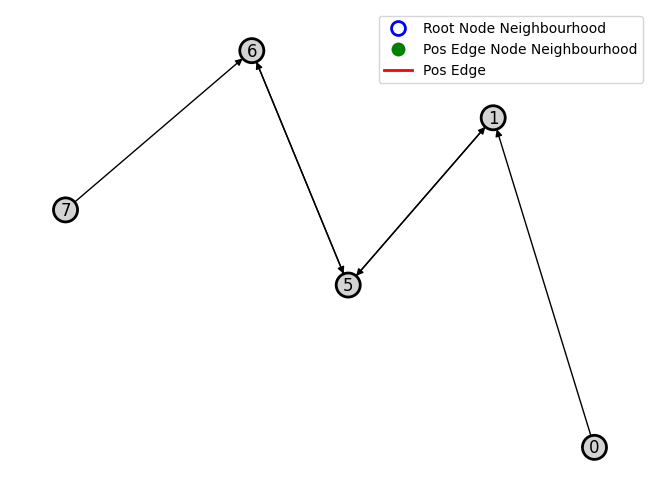

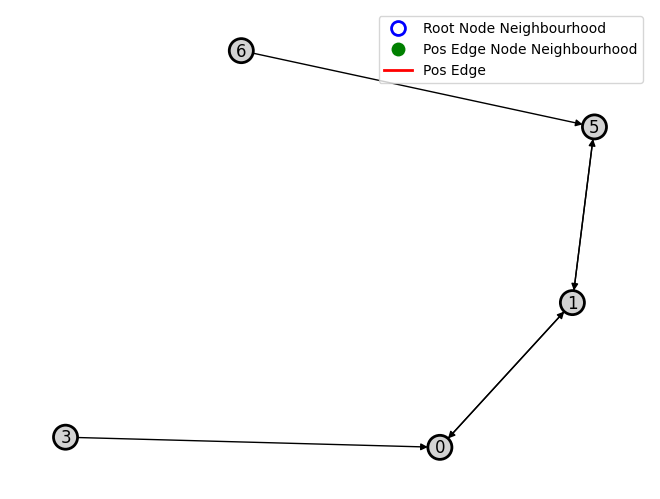

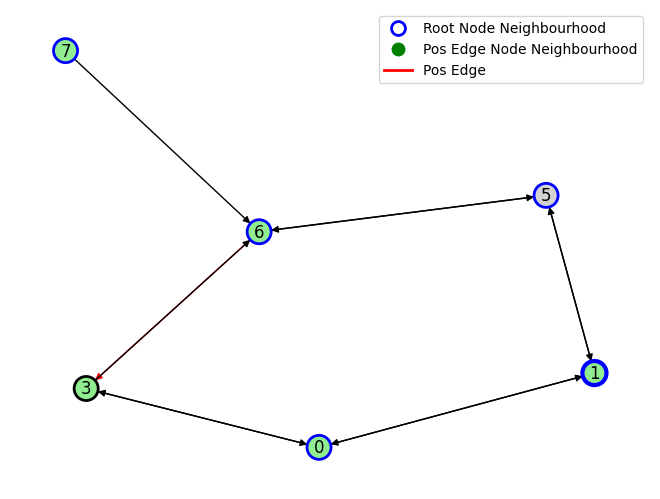

'Done Visualizing Node Prediction Sample'

In [40]:
from visualize_sgs_output import SGSVisualizer

sgs_visualizer = SGSVisualizer(frozen_config_uri)
sgs_visualizer.visualize_random_negative_sample(5)
sgs_visualizer.visualize_random_negative_sample(1)
sgs_visualizer.visualize_node_anchor_prediction_sample(5)

### Split Generator

The Split Generator reads localized subgraph samples produced by Subgraph Sampler, and executes the user specified split strategy logic to split the data into training, validation and test sets. Several standard configurations of SplitStrategy and corresponding Assigner classes are implemented already at a GiGL platform-level: transductive node classification, inductive node classification, and transductive link prediction split routines. For more information on split strategies in Graph Machine Learning checkout these resources:

1. http://web.stanford.edu/class/cs224w/slides/07-theory.pdf
2. https://zqfang.github.io/2021-08-12-graph-linkpredict/ (relevant for explaining transductive vs inductive) 

In this example, we are using the transductive strategy as specified in our frozen_config:

In [26]:
print(frozen_config.dataset_config.split_generator_config)

split_strategy_cls_path: "gigl.src.split_generator.lib.unsupervised_node_anchor_based_link_prediction.transductive.TransductiveUnsupervisedNodeAnchorBasedLinkPredictionSplitStrategy"
assigner_cls_path: "gigl.src.split_generator.lib.unsupervised_node_anchor_based_link_prediction.transductive.TransductiveEdgeToLinkSplitHashingAssigner"
assigner_args {
  key: "seed"
  value: "42"
}
assigner_args {
  key: "test_split"
  value: "0.2"
}
assigner_args {
  key: "train_split"
  value: "0.7"
}
assigner_args {
  key: "val_split"
  value: "0.1"
}



For transductive, at training time, it uses training message edges to predict training supervision edges. At validation time, the training message edges and training supervision edges are used to predict the validation edges and then all 3 are used to predict test edges. Below is the command to run split generator:


In [ ]:
%%bash

PYTHONPATH="/home/$(whoami)/GiGL/TODO/:$PYTHONPATH" python -m \
    gigl.src.split_generator.split_generator \
    --job_name toy_graph \
    --task_config_uri gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml

Upon completion, there will be 3 folders for train,test, and val. Each of them contains the protos for the positive and negaitve samples. The path for these folders is specified in the following location in the frozen_config:

In [27]:
print(frozen_config.shared_config.dataset_metadata)

unsupervised_node_anchor_based_link_prediction_dataset {
  train_main_data_uri: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/train/main_samples/samples/"
  test_main_data_uri: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/test/main_samples/samples/"
  val_main_data_uri: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/val/main_samples/samples/"
  train_random_negative_data_uri: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/train/random_negatives/neighborhoods-"
  val_random_negative_data_uri: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/val/random_negatives/neighborhoods-"
  test_random_negative_data_uri: "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/split_generator/test/random_negatives/neighborhoods-"
}




We can visualize the train,test, and val sample for the same root node as above (5) to see the pipeline process.

In [ ]:
from visualize_sgn_output import SGNVisualizer

sgn_vis = SGNVisualizer(frozen_config_uri)

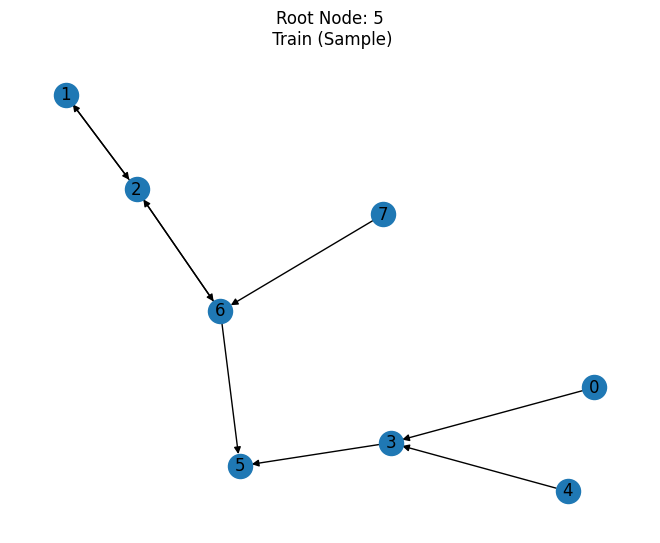

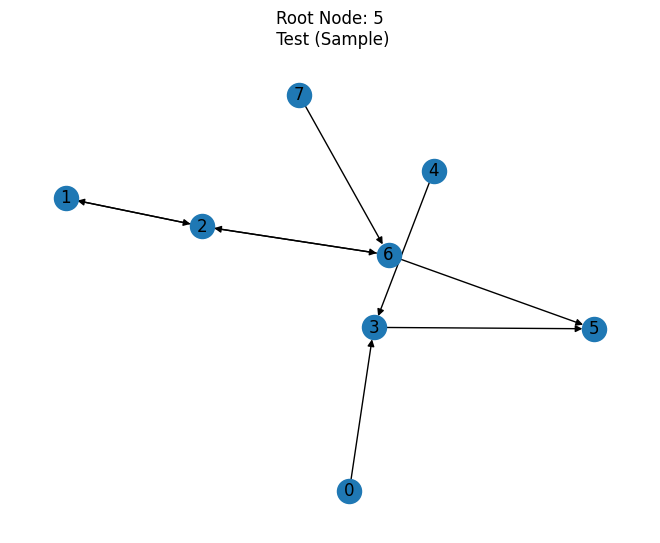

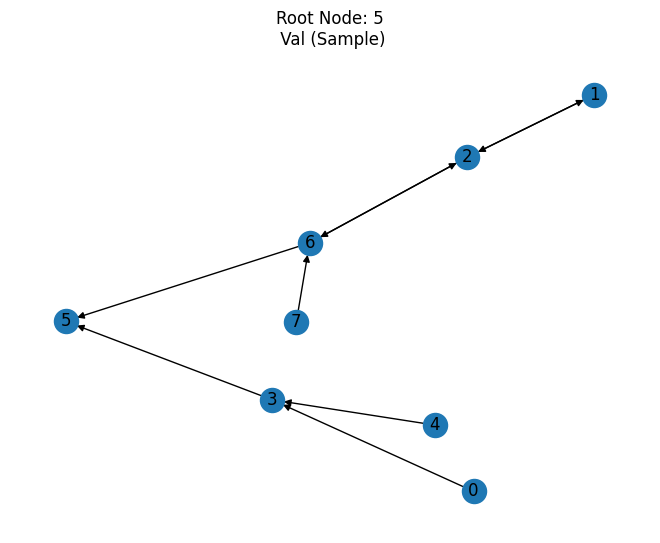

<Figure size 640x480 with 0 Axes>

In [7]:
sgn_vis.visualize_main_data_output(5)

At this point, we have our graph data samples ready to be processed by the trainer and inferencer components. These components will extract representations/embeddings by learning contextual information for the specified task.